# Tutoriel de résolution d'un problème de machine learning : reconnaissance des chiffres 1 à 10 à partir des images fournies un dataset

## Problématique étudiée

La problématique étudiée est le cas avec le dataset hand-written digits. L'objectif de ce cas est de reconnaître des chiffres annotés à la main à partir d'une base de données disponible.

Il s'agit donc d'un cas de **machine learning supervisé**, et plus spécifiquement d'un cas de **classification**.

Ce notebook va vous guider à travers ce cas concret de classification, et va utiliser un modèle particulier de machine learning pour réaliser cette tâche : les *SVM* (ou *Support Vector Machines* en anglais, soit *machines à vecteurs support* en français). Les parties suivantes sont dédiées à l'implémentation de ce modèle grâce à l'utilisation de la librairie scikit-learn.

## Code

### Importation des différentes librairies 

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split


<span style="color: #FF0000">Faire les import avant les from</span>

### Importation du dataset 

La première étape est d'importer le dataset et de voir de quoi il est constitué. Ici on importe le dataset hand-written digits.

In [2]:
# Import the hand-written digits dataset
digits = datasets.load_digits()


<span style="color: #FF0000">Pense au print pour une meilleure lisibilité du descriptif</span>

In [4]:
# Dataset description
digits.DESCR


".. _digits_dataset:\n\nOptical recognition of handwritten digits dataset\n--------------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 1797\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttps://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of on pixel

On voit grâce à la description détaillée qu'il s'agit d'un dataset qui cherche à faire de la reconnaissance optique de chiffres écrits à la main (grâce au titre), puis qu'il contient 1797 exemples de chiffres, avec 64 attributes par chiffre. Il se trouve que l'on comprend ensuite que ces attributes sont directement le nombre de pixels que contient chacune des 1797 images disponibles, chacune représentant un nombre entre 0 et 9 (c'est la partie attribute information qui nous renseigne là-dessus).

Nous sommes donc en possession de 1797 images de 8x8 pixels qui représentent des chiffres de 0 à 9.

Pour s'en assurer nous représentons quelques-uns de ces chiffres :

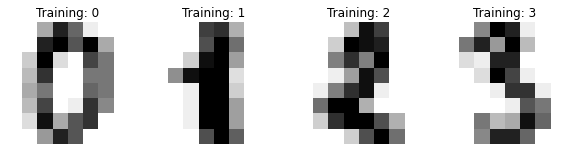

In [5]:
# Plot some data to show what they look like
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


In [6]:
digits.images[0]


array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Les images des chiffres manuscrits sont contenues dans un tableau *digits.images*. Chaque élément de ce tableau est une image représentée par une matrice 8x8 de valeurs numériques qui correspondent à des niveaux de gris allant du blanc, avec une valeur de 0, au noir, avec la valeur 15.

### Phase d'apprentissage du modèle

La première étape lors de l'utilisation d'une méthode d'apprentissage supervisée, c'est l'apprentissage. Dans cette étape, nous allons construire notre modèle en lui donnant un certain nombre d'exemples depuis notre base de données. La règle de base lors de cette étape est de séparer la base de données en deux : une partie pour l'apprentissage et une partie pour le test. Ceci afin de ne pas montrer lors de la phase de test des exemples de chiffres qui auraient servis lors de la phase d'apprentissage, car alors le test serait biaisé.

Mais pour pouvoir apprendre un modèle, ce dernier a besoin de *features*, c'est-à-dire des nombres en entrée, servant à décrire nos images dans un *langage* compris par la machine. En traitement d'images, la solution la plus simple pour produire ces *features* consiste à *vectoriser* l'image, c'est-à-dire passer l'image 8x8 sous forme d'un vecteur de taille 64, dont chaque ligne représente la valeur d'un pixel en niveau de gris. C'est ce que nous faisons juste en-dessous :

In [7]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
# Print data shape to understand with what we work
print(
    "Taille avant vectorisation : {}\nTaille après vectorisation : {}".format(
        digits.images.shape, data.shape
    )
)

Taille avant vectorisation : (1797, 8, 8)
Taille après vectorisation : (1797, 64)


Puis, nous divisons notre jeu de données d'entrée en deux sous-ensembles, afin de constituer nos jeux de données d'apprentissage (constitué ici de 70 % des données de départ), et de test (30 % des données de départ).

In [8]:
# Split data into 70% train and 30% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.3, shuffle=False
)


Vous pouvez tester différents pourcentages de répartition des données et regarder l'effet de ces changements sur les différentes metrics (plus bas dans ce notebook).

Puis nous choisissons le modèle à mettre en place, nous l'apprenons, et nous le testons dans la foulée :

In [9]:
# Create a classifier: a support vector classifier
clf = svm.SVC(kernel="rbf", gamma=0.001, C=1)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)


Enfin, nous regardons quelques résultats de prédiction, pour voir de manière qualitative si le modèle semble bien fonctionner.

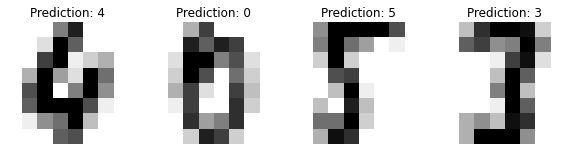

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")


### Vérification des résultats pour valider le modèle 

Une étape essentielle après l'apprentissage et le test d'un modèle de machine learning est l'analyse de ses performances afin de valider s'il fonctionne ou non. Pour ce faire, nous utilisons différentes métriques, dont nous vous invitons à aller chercher les définitions en ligne : la précision, le recall, et le f1-score. Ces métriques doivent toutes tendre vers 1 lorsque le modèle fonctionne bien.

In [11]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)


Classification report for classifier SVC(C=1, gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.96      1.00      0.98        53
           2       1.00      0.98      0.99        53
           3       0.96      0.89      0.92        53
           4       0.98      0.95      0.96        57
           5       0.95      0.98      0.96        56
           6       0.98      0.98      0.98        54
           7       1.00      1.00      1.00        54
           8       0.91      0.98      0.94        52
           9       0.96      0.96      0.96        55

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540




On constate que les résultats sont très corrects. La classe 8 est la moins bien reconnue. Il est intéressant de voir que le nombre d'images testées par classe est à peu près égal, ce qui assure une bonne représentativité de chaque classe dans les résultats (on parle de problème équilibré). Il est important de s'assurer de cet équilibre dès la phase d'apprentissage pour être certain de ne pas biaiser l'apprentissage de certaines classes (une classe sous-représentée pourrait être très peu prédite en pratique). On retrouve bien ici que 540 images en test représentent eniron 30 % de 1764 images du jeu de données complet, ce qui est cohérent.

Pour analyser plus finement les résultats, on représente enuite la matrice de confusion, qui montre pour chaque classe le nombre de bonnes et mauvaises classification, et ce de manière croisée pour savoir dans quelles classes ont été prédites les erreurs de classification :

Confusion matrix:
[[52  0  0  0  1  0  0  0  0  0]
 [ 0 53  0  0  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0  0  0]
 [ 0  0  0 47  0  2  0  0  4  0]
 [ 0  0  0  0 54  0  0  0  1  2]
 [ 0  0  0  0  0 55  1  0  0  0]
 [ 0  1  0  0  0  0 53  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  1  0  0  0  0  0  0 51  0]
 [ 0  0  0  1  0  1  0  0  0 53]]


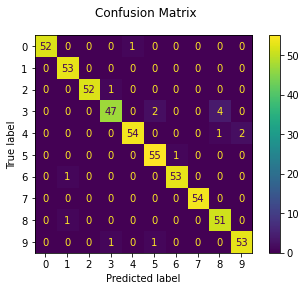

In [12]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()


On remarque alors que les erreurs observés au global pour la classe 3 se concentrent dans la classe 8 et 5, et une analyse plus approfondie peut alors être menée pour déterminer pourquoi ces erreurs se font spécifiquement sur ces classes-là.

On peut conclure que le modèle *SVM* est plus fiable que le modèle *random forest* pour cette problématique avec ces données (cf Tutoriel ML1).

## Exemple avec différents paramètres

Ici nous allons tester différents paramètres pour le modèle SVM et nottament faire varier le kernel et le gamma pour voir l'incidence sur les prévisions et les metrics.

### Kernel

Paramètre Kernel : Les algorithmes SVM utilisent un ensemble de fonctions mathématiques qui sont définies comme le noyau (= Kernel). La fonction du noyau est de prendre des données en entrée et de les transformer dans la forme requise. Les différents algorithmes SVM utilisent différents types de fonctions de noyau. Ces fonctions peuvent être de différents types. Par exemple, linéaire, non linéaire, polynomiale, fonction de base radiale (RBF) et sigmoïde.

Classification report for classifier SVC(C=1, gamma=0.001):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        53
           1       0.92      0.91      0.91        53
           2       1.00      0.96      0.98        53
           3       0.90      0.85      0.87        53
           4       0.98      0.93      0.95        57
           5       0.95      0.98      0.96        56
           6       0.96      0.98      0.97        54
           7       0.96      0.96      0.96        54
           8       0.82      0.87      0.84        52
           9       0.88      0.91      0.89        55

    accuracy                           0.93       540
   macro avg       0.93      0.93      0.93       540
weighted avg       0.93      0.93      0.93       540




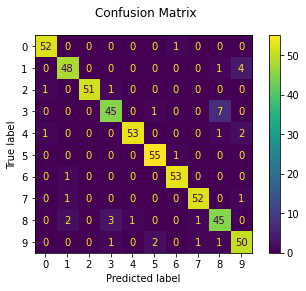

In [26]:
# Test avec un kernel linéaire
clf2 = svm.SVC(kernel="linear", C=1)
clf2.fit(X_train, y_train)
predicted2 = clf2.predict(X_test)

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted2)}\n"
)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted2)
disp.figure_.suptitle("Confusion Matrix")

plt.show()


Classification report for classifier SVC(C=1, gamma=0.001):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        53
           1       0.96      0.94      0.95        53
           2       1.00      0.94      0.97        53
           3       0.92      0.89      0.90        53
           4       0.98      0.95      0.96        57
           5       0.93      0.98      0.96        56
           6       0.96      0.98      0.97        54
           7       0.95      0.98      0.96        54
           8       0.91      0.94      0.92        52
           9       0.91      0.91      0.91        55

    accuracy                           0.95       540
   macro avg       0.95      0.95      0.95       540
weighted avg       0.95      0.95      0.95       540




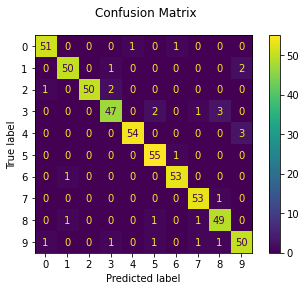

In [27]:
# Test avec un kernel poly
clf3 = svm.SVC(kernel="poly", degree=3, gamma="auto", C=1)
clf3.fit(X_train, y_train)
predicted3 = clf3.predict(X_test)

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted3)}\n"
)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted3)
disp.figure_.suptitle("Confusion Matrix")

plt.show()


On peur voir que les différents Kernel donnent des score différents, le meilleur kernel est le 'rbf'.

### Gamma

Paramètre Gamma :
Le paramètre gamma définit la portée de l'influence d'un seul exemple d'apprentissage. Cela signifie qu'un Gamma élevé ne prendra en compte que les points proches de l'hyperplan plausible et qu'un Gamma faible prendra en compte les points plus éloignés.

Classification report for classifier SVC(C=1, gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        53
           1       1.00      0.60      0.75        53
           2       1.00      0.60      0.75        53
           3       1.00      0.74      0.85        53
           4       1.00      0.65      0.79        57
           5       1.00      0.73      0.85        56
           6       1.00      0.54      0.70        54
           7       1.00      0.63      0.77        54
           8       0.24      1.00      0.39        52
           9       1.00      0.80      0.89        55

    accuracy                           0.70       540
   macro avg       0.92      0.70      0.75       540
weighted avg       0.93      0.70      0.76       540




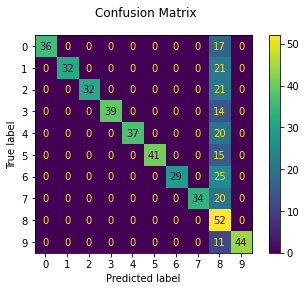

In [28]:
# Test avec un gamma différent
clf4 = svm.SVC(kernel="rbf", gamma=0.01, C=1)
clf4.fit(X_train, y_train)
predicted4 = clf4.predict(X_test)

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted4)}\n"
)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted4)
disp.figure_.suptitle("Confusion Matrix")

plt.show()


On peur voir que le gamma à aussi une influence sur les metrics. Un gamma de 0.001 donne de meilleurs résultats qu'un gamme de 0.01.

# C

Paramètre de régularisation :
Le paramètre de régularisation (appelé C en python) indique à l'optimisation SVM dans quelle mesure vous souhaitez éviter les erreurs de classification pour chaque exemple d'apprentissage. Si le C est plus élevé, l'optimisation choisira un hyperplan de marge plus petit, ainsi le taux de classification erronée des données d'entraînement sera plus faible. D'autre part, si le C est faible, la marge sera grande, même s'il y aura des exemples de données de formation mal classés. 

Classification report for classifier SVC(C=1, gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.96      1.00      0.98        53
           2       1.00      0.98      0.99        53
           3       0.96      0.91      0.93        53
           4       0.98      0.95      0.96        57
           5       0.95      0.98      0.96        56
           6       0.98      0.98      0.98        54
           7       1.00      1.00      1.00        54
           8       0.94      0.98      0.96        52
           9       0.95      0.96      0.95        55

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540




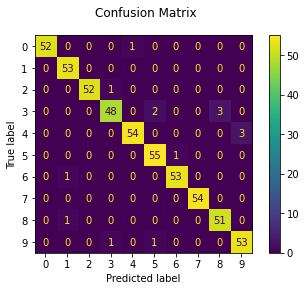

In [32]:
# Test avec un C différent
clf5 = svm.SVC(kernel="rbf", gamma=0.001, C=200)
clf5.fit(X_train, y_train)
predicted5 = clf5.predict(X_test)

print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted5)}\n"
)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted5)
disp.figure_.suptitle("Confusion Matrix")

plt.show()


Ici un C de 200 donne les mêmes résultats que un C de 1.

### C'est la fin de ce tuto sur le modèle de SVM. Vous pouvez tester ce modèle avec d'autres paramètres (Kernel, gamma, C, % de séparation des données tests/trains...) ou d'autres données.

<span style="color: #FF0000">Avec ce que tu as montré tu pourrai finir sur une conclusion qui montre que l'usage d'un modèle plus ou moins complexe dépend de la complexité du problème. En l'occurence ici comme nous avons un prblème simple, nous n'avons pas besoin d'utiliser des kernel pour améliorer nos résultats, nous n'avons pas besoin d'un grand nombre de donnée train pour que le SVM ai un score élevé. nous n'avons pas besoin d'utiliser un réseau de neuronne qui est beaucoup plus complexe et long à ce lancer que le SVM, car ce dernier est déjç très efficace. Tu peux donc montrer qu'il faut adapter la complexité du modèle à la complexité du problème, de la même façon que l'on n'utilise pas un lance flamme pour allumer un barbecue</span>